In [40]:
#reading data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind



patent_data = pd.read_csv("2023.csv",low_memory=False)



Patent Grant Time Analysis

This analysis explores how long it takes for a U.S. patent to be granted, using publicly available patent data.

We’ll focus on comparing time to grant (in years) across two main dimensions:
- Technology field, using the `first_wipo_field_title`  a broad categorization of the subject area of the patent
- Assignee type, i.e., whether the patent was filed by an Individual or an Organization

The `first_wipo_field_title` was chosen because it provides a balanced variety of fields — general enough for grouping, but specific enough to show real differences.

Finally, we’ll examine the top patent fields for Individuals vs. Organizations and explore whether differences in patent portfolios may influence grant times across assignee types.

Hypotheses

1. Technology Field Hypothesis  
   Fields related to digital technology, communications, and AI will, on average, have shorter grant times.  
   Fields like pharmaceuticals, medical technology, and mechanical/engineering will take longer due to their complexity and regulatory scrutiny.

2. Assignee Type Hypothesis  
   Patents filed by Individuals will, on average, take longer to grant than those filed by Organizations, potentially due to differences in legal resources, filing quality, and prosecution efficiency.


In [41]:
# preparing data for analysis by keeping and creating relevant columns and removing Null values 
patent_data["assignee_type"] = patent_data["assignee_ind"].map({1:"Individual", 0:"Organization"})
patent_data["years_to_grant"] = patent_data["grant_year"] - patent_data["application_year"]
patent_data = patent_data.loc[patent_data["first_wipo_field_title"].notna()]
patent_data = patent_data.loc[:,["years_to_grant","first_wipo_field_title","assignee_type"]]
patent_data.rename(columns={"first_wipo_field_title":"field"},inplace=True)
patent_data


,years_to_grant,field,assignee_type
0,4,Other special machines,Organization
1,3,Other special machines,Organization
2,3,Other special machines,Organization
3,3,Other special machines,Organization
4,6,Other special machines,Organization
...,...,...,...
328068,2,Computer technology,Organization
328071,2,Computer technology,Organization
328072,3,Computer technology,Organization
328074,2,Computer technology,Organization


In [42]:
# Setting all the fields here we will keep the top fields (>7000 patents ) and set the rest to other

top_fields = [
    "Computer technology", "Digital communication", "Electrical machinery, apparatus, energy",
    "Medical technology", "Semiconductors", "Measurement", "Optics",
    "Pharmaceuticals", "Other special machines", "Telecommunications"
]
def isTop(field):
    if(top_fields.__contains__(field)):
        return field
    else:
        return "Other"
    

# we will save all the field data for both the individuals and organizations so we can compare the field popularity in the end

indiv_data = patent_data.loc[patent_data["assignee_type"] == "Individual"]
org_data = patent_data.loc[patent_data["assignee_type"] == "Organization"]
indivField = indiv_data.loc[:].groupby("field").size().reset_index(name='patent_count')
orgField = org_data.loc[:].groupby("field").size().reset_index(name='patent_count')


patent_data["field"] = patent_data["field"].apply(isTop)

fields =  patent_data.loc[:].groupby("field").size().reset_index(name='patent_count')
fields = fields.sort_values(by="patent_count", ascending=False).reset_index(drop=True)
fields


,field,patent_count
0,Other,125796
1,Computer technology,51470
2,Digital communication,34940
3,Medical technology,23789
4,"Electrical machinery, apparatus, energy",22516
5,Measurement,15666
6,Semiconductors,14812
7,Optics,11255
8,Pharmaceuticals,8819
9,Other special machines,7593


In [43]:
# make the data that we will use for the field
field_Data = patent_data.groupby("field")["years_to_grant"].agg(mean = "mean", std = "std").reset_index()
field_Data

,field,mean,std
0,Computer technology,2.474937,1.301975
1,Digital communication,2.449857,1.346251
2,"Electrical machinery, apparatus, energy",2.576834,1.351685
3,Measurement,2.792800,1.370461
4,Medical technology,3.197991,1.578045
5,Optics,2.396890,1.264479
6,Other,2.742822,1.493092
7,Other special machines,2.993810,1.527010
8,Pharmaceuticals,3.390294,1.838347
9,Semiconductors,2.428774,1.132259


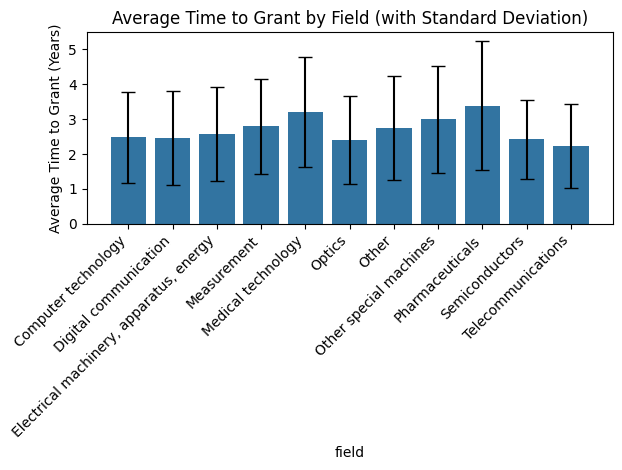

In [44]:

ax = sns.barplot(data=field_Data, x="field", y="mean")

# Add error bars manually
plt.errorbar(
    x=ax.get_xticks(),
    y=field_Data["mean"],
    yerr=field_Data["std"],
    fmt='none',
    c='black',
    capsize=5
)

plt.xticks(rotation=45, ha='right')
plt.ylabel("Average Time to Grant (Years)")
plt.title("Average Time to Grant by Field (with Standard Deviation)")
plt.tight_layout()
plt.show()

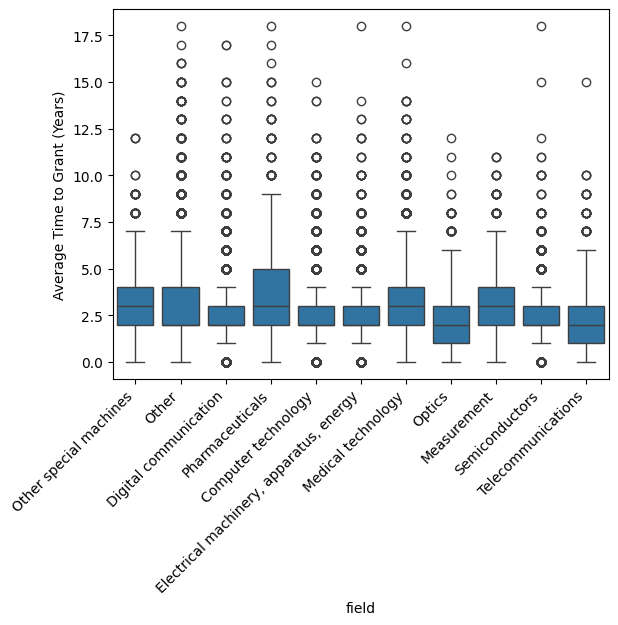

In [45]:
sns.boxplot(data=patent_data, x="field", y="years_to_grant")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Average Time to Grant (Years)")
plt.show()

# patent_data


In [46]:
#compare the assignee_types
assignee_type = patent_data.loc[:].groupby("assignee_type").size().reset_index(name='patent_count')
assignee_type

,assignee_type,patent_count
0,Individual,2694
1,Organization,321128


In [47]:
# we balance the data by taking a random sample in the organizations table
balanced_org_data = org_data.sample(n = indiv_data.shape[0],random_state=42)
balanced_data = pd.concat([indiv_data,balanced_org_data])
balanced_assignee_type = balanced_data.loc[:].groupby("assignee_type").size().reset_index(name='patent_count')
balanced_assignee_type


,assignee_type,patent_count
0,Individual,2694
1,Organization,2694


In [48]:
#retrieve data for the organizations
balanced_assignee_type_data = balanced_data.groupby("assignee_type")["years_to_grant"].agg(mean = "mean", std = "std").reset_index()
balanced_assignee_type_data

,assignee_type,mean,std
0,Individual,2.706756,1.551724
1,Organization,2.688196,1.468077


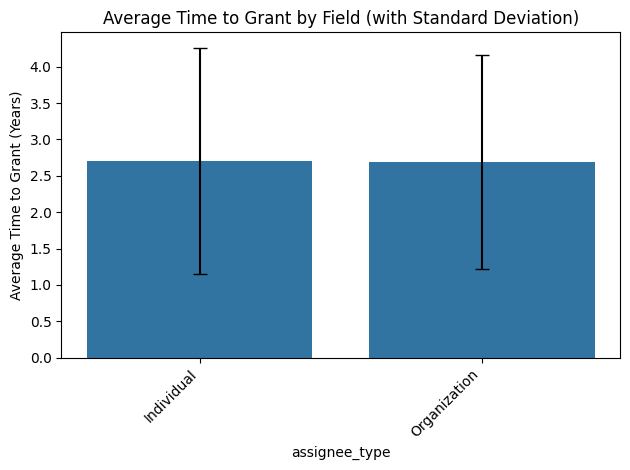

In [49]:
ax = sns.barplot(data=balanced_assignee_type_data, x = "assignee_type", y= "mean", legend=False)
plt.errorbar(
    x=ax.get_xticks(),
    y=balanced_assignee_type_data["mean"],
    yerr=balanced_assignee_type_data["std"],
    fmt='none',
    c='black',
    capsize=5
)

plt.xticks(rotation=45, ha='right')
plt.ylabel("Average Time to Grant (Years)")
plt.title("Average Time to Grant by Field (with Standard Deviation)")
plt.tight_layout()
plt.show()


In [50]:
# We now run a  t-test to test for a significant difference between both
balanced_org_data_years = balanced_org_data.loc[:,["years_to_grant"]]
indiv_data_years = indiv_data.loc[:,["years_to_grant"]]
org_years = pd.to_numeric(balanced_org_data_years["years_to_grant"], errors="coerce")
indiv_years = pd.to_numeric(indiv_data_years["years_to_grant"], errors="coerce")



In [51]:
t_stat,p_value=ttest_ind(indiv_years,org_years,equal_var=False)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 0.4509634377012761
P-value: 0.6520341106994155


In [52]:
total_count = indivField["patent_count"].sum()
indivField["patent_count"] = (indivField["patent_count"]/ total_count) * 100
indivField.rename(columns={"patent_count": "percentage_of_patents"}, inplace=True)
indivField = indivField.sort_values( by ="percentage_of_patents", ascending = False).reset_index(drop = True)
indivField


,field,percentage_of_patents
0,"Engines, pumps, turbines",15.775798
1,Medical technology,10.207869
2,"Electrical machinery, apparatus, energy",6.421678
3,Computer technology,5.976244
4,Other special machines,5.679287
5,"Furniture, games",4.788419
6,Transport,4.602821
7,Digital communication,3.897550
8,Measurement,3.786192
9,Civil engineering,3.711952


In [53]:
total = orgField["patent_count"].sum()
orgField["patent_count"] = (orgField["patent_count"]/ total) * 100
orgField.rename(columns={"patent_count": "percentage_of_patents"}, inplace=True)
orgField = orgField.sort_values( by ="percentage_of_patents", ascending = False).reset_index(drop = True)
orgField

,field,percentage_of_patents
0,Computer technology,15.977741
1,Digital communication,10.847699
2,Medical technology,7.322314
3,"Electrical machinery, apparatus, energy",6.957662
4,Measurement,4.846666
5,Transport,4.805560
6,Semiconductors,4.607197
7,Audio-visual technology,4.152550
8,Optics,3.496737
9,Pharmaceuticals,2.716051
